# Анализ влияния рекомендательной системы на ARPPU

В данном ноутбуке мы проанализируем влияние рекомендательной системы на:
1. ARPPU power users (95-й процентиль)
2. ARPPU всех пользователей

Рекомендательная система предлагает похожие или комплементарные товары после добавления товара в корзину.

In [11]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# Настройки для графиков
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set(font_scale=1.2)

In [12]:
# Загрузка данных
print("Загружаем данные...")
logs = pd.read_pickle('ab_test_logs.pkl')
print("Данные загружены успешно!")

# Посмотрим на структуру данных
print("\nСтруктура данных:")
print(logs.info())

print("\nПервые несколько строк:")
print(logs.head())

Загружаем данные...
Данные загружены успешно!

Структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31525 entries, 0 to 31524
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     31525 non-null  object        
 1   dt          31525 non-null  datetime64[ns]
 2   event       31525 non-null  object        
 3   group       31525 non-null  object        
 4   visit_id    31525 non-null  object        
 5   cart_id     31525 non-null  object        
 6   amount      25831 non-null  float64       
 7   num_items   25831 non-null  float64       
 8   old_amount  25831 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 2.2+ MB
None

Первые несколько строк:
  user_id                  dt      event    group visit_id cart_id  amount  \
0  user_0 2025-03-06 00:00:00   cart-add     test  visit_1  cart_0   43.22   
1  user_0 2025-03-06 00:01:00   cart-add  

In [13]:
def calculate_user_revenue(data):
    """Рассчитывает выручку по каждому пользователю"""
    # Находим платящих пользователей
    purchase_events = data[data['event'] == 'cart-paid']
    paid_carts = purchase_events['cart_id'].unique()
    
    # Находим все события добавления товаров в оплаченные корзины
    cart_add_events = data[
        (data['event'] == 'cart-add') & 
        (data['cart_id'].isin(paid_carts))
    ]
    
    # Группируем по пользователям и считаем сумму покупок
    user_revenue = cart_add_events.groupby(['user_id', 'group'])['amount'].sum().reset_index()
    
    return user_revenue

# Рассчитываем выручку по пользователям
user_revenue = calculate_user_revenue(logs)

# Определяем power users (95-й процентиль)
revenue_threshold = user_revenue['amount'].quantile(0.95)
power_users = user_revenue[user_revenue['amount'] >= revenue_threshold]

print(f"Порог для power users (95-й процентиль): {revenue_threshold:.2f}")
print(f"Количество power users: {len(power_users)}")

Порог для power users (95-й процентиль): 1999.82
Количество power users: 194


In [14]:
def analyze_arppu_difference(revenue_data, group_name=""):
    """Анализирует разницу в ARPPU между контрольной и тестовой группами"""
    # Разделяем на контрольную и тестовую группы
    control_data = revenue_data[revenue_data['group'] == 'control']['amount']
    test_data = revenue_data[revenue_data['group'] == 'test']['amount']
    
    # Рассчитываем ARPPU для обеих групп
    control_arppu = control_data.mean()
    test_arppu = test_data.mean()
    
    # Проводим статистический тест
    t_stat, p_value = stats.ttest_ind(control_data, test_data, equal_var=False)
    
    print(f"\nАнализ ARPPU для {group_name}:")
    print(f"ARPPU контрольной группы: {control_arppu:.2f}")
    print(f"ARPPU тестовой группы: {test_arppu:.2f}")
    print(f"Абсолютная разница: {test_arppu - control_arppu:.2f}")
    print(f"Относительная разница: {((test_arppu - control_arppu) / control_arppu * 100):.2f}%")
    print(f"p-value: {p_value:.4f}")
    
    return control_data, test_data, p_value

# Анализируем ARPPU для power users
power_users_results = analyze_arppu_difference(power_users, "power users")

# Анализируем ARPPU для всех пользователей
all_users_results = analyze_arppu_difference(user_revenue, "всех пользователей")


Анализ ARPPU для power users:
ARPPU контрольной группы: 3337.05
ARPPU тестовой группы: 4035.22
Абсолютная разница: 698.17
Относительная разница: 20.92%
p-value: 0.0144

Анализ ARPPU для всех пользователей:
ARPPU контрольной группы: 536.32
ARPPU тестовой группы: 574.44
Абсолютная разница: 38.12
Относительная разница: 7.11%
p-value: 0.2040


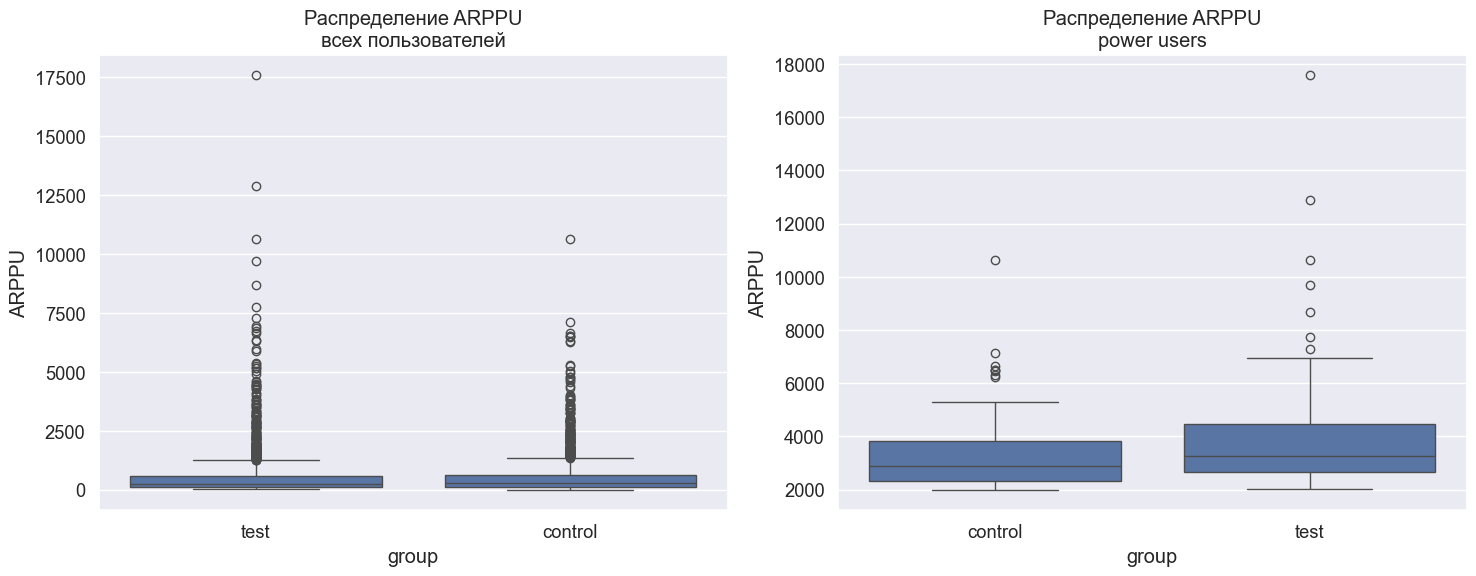

In [15]:
# Визуализация распределения ARPPU
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График для всех пользователей
sns.boxplot(data=user_revenue, x='group', y='amount', ax=ax1)
ax1.set_title('Распределение ARPPU\nвсех пользователей')
ax1.set_ylabel('ARPPU')

# График для power users
sns.boxplot(data=power_users, x='group', y='amount', ax=ax2)
ax2.set_title('Распределение ARPPU\npower users')
ax2.set_ylabel('ARPPU')

plt.tight_layout()
plt.savefig('arppu_distribution.png')
plt.show()

Выводы
Влияние на power users (95-й процентиль):
     Power users — пользователи с выручкой выше 1999.82 (95-й процентиль).
     Всего выявлено 194 power users.
     ARPPU в контрольной группе: 3337.05.
	 ARPPU в тестовой группе: 4035.22.
	 Увеличение ARPPU на 698.17 (20.92%).
	 Результат статистически значим (p-value = 0.0144 < 0.05).
Влияние на всех пользователей:
     ARPPU в контрольной группе: 536.32.
	 ARPPU в тестовой группе: 574.44.
	 Увеличение ARPPU на 38.12 (7.11%).
	 Результат статистически незначим (p-value = 0.2040 > 0.05).
Общие наблюдения и рекомендации:
     Рекомендательная система значительно увеличивает ARPPU power users (>20%).
     Эффект на всех пользователей положительный (+7.11%), но статистически незначим.
     Система особенно эффективна для активных пользователей с высоким средним чеком.
Рекомендации:
     Внедрить систему, так как она увеличивает выручку от ценных клиентов.
     Провести дополнительное исследование для улучшения эффекта на всех пользователей.
     Рассмотреть персонализацию рекомендаций с учетом уровня активности пользователей.